## Hypothesis Test Example with Toys


This notebook performs an hypothesis test and computes the significance of the test (p-value) using the asympotic approximation of the profile likelihood function.

The test statistics for computing the hypothesis test is 

$$q_\mu = - 2 \log \frac { L( x \ | \ \mu , \hat{\hat{\nu} } ) }{  L( x \ | \ \hat{\mu} , \hat{\nu}  ) } \  \  \ \mathrm{for} \  \  
\hat{\mu}  >  0$$
$$q_\mu = 0     \hspace{3cm}     \ \mathrm{for} \  \  
\hat{\mu} \le  0$$

Pseudo-experimets are used to obtain the test statistics distribution for the two hypothesis

In [1]:
using namespace RooStats;

In [2]:
HypoTestResult * result = nullptr;
ProfileLikelihoodTestStat * testStat = nullptr; 
ToyMCSampler * toymcs = nullptr; 
HypoTestPlot * plot = nullptr; 
// enable use of NLL offset for better minimizations
RooStats::UseNLLOffset(true);


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



#### Set the number of expected events used to compute the expected significance

In [3]:
int nexp_events = 250; 

TString fileName ="HiggsBinModel.root";  // for s simplified model
//TString fileName ="HiggsBinModelSimple.root";  
TString workspaceName = "w";
TString modelConfigName = "ModelConfig";
TString dataName = "data";
TString integrationType = "";  
//ROOT::Math::MinimizerOptions::SetDefaultMinimizer("Minuit2");

#### Reading the model (Workspace) from input file

First part is just to access the workspace file and retrieve the model and the data 

In [4]:
auto file = TFile::Open(fileName);
auto w =  (RooWorkspace*) file->Get(workspaceName);
w->Print();
auto sbModel = (RooStats::ModelConfig*) w->obj(modelConfigName);
auto  data = w->data(dataName);
auto poi = (RooRealVar*) sbModel->GetParametersOfInterest()->first();


RooWorkspace(w) w contents

variables
---------
(a1,a2,mass,nbackground,nsignal,width,x)

p.d.f.s
-------
RooExponential::bmodel[ x=z c=1 ] = 0.000354025
RooAddPdf::model[ nbackground * bmodel + nsignal * smodel ] = 0.000350859
RooGaussian::smodel[ x=x mean=mass sigma=width ] = 1.8233e-12

functions
--------
RooFormulaVar::z[ actualVars=(a1,a2,x) formula="-(a1*x/100.+a2*(x/100.)^2)" ] = -7.94614

datasets
--------
RooDataHist::data(x)

named sets
----------
ModelConfig_NuisParams:(a1,a2,nbackground)
ModelConfig_Observables:(x)
ModelConfig_POI:(nsignal)
nuisParams:(a1,a2,nbackground)

generic objects
---------------
RooStats::ModelConfig::ModelConfig



##### Make the b Model by cloning the b model and use a value = 0 for the parameter of interest

In [5]:
auto bModel = (RooStats::ModelConfig*) sbModel->Clone();
sbModel->SetName("S+B Model");
poi->setVal(nexp_events);
sbModel->SetSnapshot( *poi);
bModel->SetName("B Model");
poi->setVal(0);
bModel->SetSnapshot( *poi  );
sbModel->Print();
bModel->Print();


=== Using the following for S+B Model ===
Observables:             RooArgSet:: = (x)
Parameters of Interest:  RooArgSet:: = (nsignal)
Nuisance Parameters:     RooArgSet:: = (a1,a2,nbackground)
PDF:                     RooAddPdf::model[ nbackground * bmodel + nsignal * smodel ] = 0.000354025
Snapshot:                
  1) 0x123adb740 RooRealVar:: nsignal = 250 +/- 93.6477  L(0 - 1000)  "nsignal"


=== Using the following for B Model ===
Observables:             RooArgSet:: = (x)
Parameters of Interest:  RooArgSet:: = (nsignal)
Nuisance Parameters:     RooArgSet:: = (a1,a2,nbackground)
PDF:                     RooAddPdf::model[ nbackground * bmodel + nsignal * smodel ] = 0.000354025
Snapshot:                
  1) 0x103386ba0 RooRealVar:: nsignal = 0 +/- 93.6477  L(0 - 1000)  "nsignal"



We set the mass and the width to constant. 
We  fix also the background parameters $a_1$ and $a_2$ to speed up  the pseudo-experiment generation.

In [6]:
w->var("a1")->setConstant(true);
w->var("a2")->setConstant(true);

w->var("mass")->setConstant(true);
w->var("width")->setConstant(true);

### Run Asymptotic calculator to obtain asymptotic significance

In [7]:
RooStats::AsymptoticCalculator::SetPrintLevel(-1);  // to switch off print level 
RooStats::AsymptoticCalculator  asymCalc(*data, *sbModel, *bModel);

[#0] PROGRESS:Eval -- AsymptoticCalculator: Building Asimov data Set


Configure the calculator

In [8]:
asymCalc.SetOneSidedDiscovery(true);  // for one-side discovery test
asymCalc.SetPrintLevel(-1);  // to suppress print level 

Run the calculator and get the result

In [9]:
result = asymCalc.GetHypoTest();
result->Print();


Results HypoTestAsymptotic_result: 
 - Null p-value = 3.187e-05
 - Significance = 3.99852
 - CL_b: 3.187e-05
 - CL_s+b: 0.357655
 - CL_s: 11222.3


In [10]:
std::cout << "Asymptotic significance = " << result->Significance() << " for p-value = " << result->NullPValue() << std::endl; 

Asymptotic significance = 3.99852 for p-value = 3.187e-05


### Run the Frequentist Calculator to compute significance using toys

We run now on the same model the FrequentistCalculator. The Frequentist Calculator uses the test statistic distributions obtained with pseudo-experiments.

In [11]:
RooStats::FrequentistCalculator   fc(*data, *sbModel, *bModel);
// to enable Proof
RooStats::ProofConfig pc(*w, 0, "", kFALSE);

We configure the Frequentist calculator by specifying the number of toys for the two hypothesis 

We need also to specify the test statistics type. Here are some possible test statistics to use 

In [12]:
testStat = new RooStats::ProfileLikelihoodTestStat(*sbModel->GetPdf());
// needed for PL test statistics
testStat->SetOneSidedDiscovery(true);
// to enable debug of fitting toys
// ((RooStats::ProfileLikelihoodTestStat *)testStat)->SetPrintLevel(1);

In [13]:
toymcs = (RooStats::ToyMCSampler*)fc.GetTestStatSampler();
toymcs->SetTestStatistic(testStat);
toymcs->SetGenerateBinned(true);
// toymcs->SetProofConfig(&pc);    // to use PROOF 

In [14]:
// for number counting experiments (i.e. when we have only one event per toy)
// in general shape cases are extended model
if (!sbModel->GetPdf()->canBeExtended())
    toymcs->SetNEventsPerToy(1);

#### Set the number of pseudo-experiments

In [15]:
fc.SetToys(2000,500);    // 2000 for null (B) and 500 for alt (S+B) 

#### Run now the calculator. 

It can take some time... be patient 

In [16]:
tw = new TStopwatch(); tw->Start(); // to print the time
result = fc.GetHypoTest(); 
result->Print();
tw->Print();


=== Using the following for B Model ===
Observables:             RooArgSet:: = (x)
Parameters of Interest:  RooArgSet:: = (nsignal)
Nuisance Parameters:     RooArgSet:: = (a1,a2,nbackground)
PDF:                     RooAddPdf::model[ nbackground * bmodel + nsignal * smodel ] = 0.0426709/1
Snapshot:                
  1) 0x11e7c95f0 RooRealVar:: nsignal = 0 +/- 93.6477  L(0 - 1000)  "nsignal"


=== Using the following for S+B Model ===
Observables:             RooArgSet:: = (x)
Parameters of Interest:  RooArgSet:: = (nsignal)
Nuisance Parameters:     RooArgSet:: = (a1,a2,nbackground)
PDF:                     RooAddPdf::model[ nbackground * bmodel + nsignal * smodel ] = 0.0426709/1
Snapshot:                
  1) 0x11e7c95f0 RooRealVar:: nsignal = 250 +/- 93.6477  L(0 - 1000)  "nsignal"

[#0] PROGRESS:Generation -- Test Statistic on data: 7.99408
[#1] INFO:InputArguments -- Profiling conditional MLEs for Null.
[#1] INFO:InputArguments -- Using a ToyMCSampler. Now configuring for Null.
[#0

Plot now the test statistics distributions

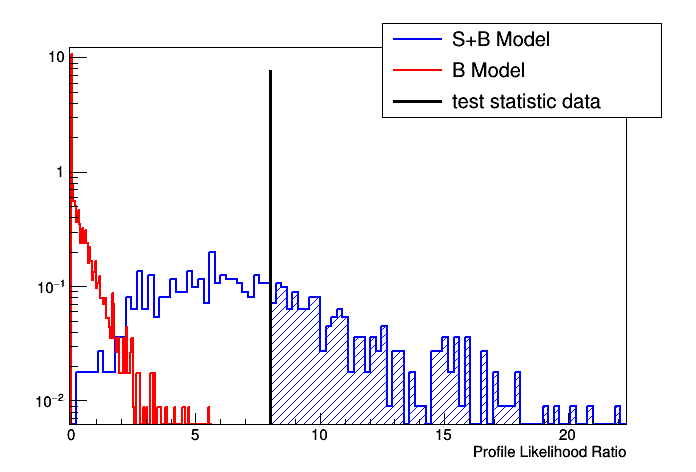

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [17]:
plot = new RooStats::HypoTestPlot(*result);
plot->SetLogYaxis(true);
plot->Draw();
gPad->Draw();

We save the result in a file. We don;t want to loose the resulting information if we have run toys for some time. 

In [18]:
fileOut = TFile::Open("HypoTestResult.root","RECREATE");
result->Write();
fileOut->Close();

#### Is Test statistic distribution like a chi-square distribution with n.d.f =1 ? 

We want to fit the null test statistic distribution to check if it is compatible with a chi2 distribution

In [19]:
dist = result->GetNullDistribution();
vec = dist->GetSamplingDistribution();
cout << "number of null toys = " << vec.size() << endl;

hdist = new TH1D("hdist","Test Statistic distribution",200,0,10);

hdist->FillN(vec.size(),vec.data(),nullptr);
// merge all underflows (failing fits) in the first bin (bin 0)
hdist->SetBinContent(1, hdist->GetBinContent(0)+hdist->GetBinContent(1));

number of null toys = 2000


In [20]:
%jsroot off

Create the fit function as a 1/2 chisquared. Special case for forst bin (x < 0.05) 
Also the quantity plotted is the log-likelihood ratio and not 2 x log-likelihood ratio .
0.05 is the histogram bin width. 

In [21]:
fchi2 = new TF1("chi2","[](double*x,double*p){ if (x[0] < 0.05) { return 0.5*p[0]+ 0.5*p[0]*ROOT::Math::chisquared_cdf(0.1,p[1]); } else { return 0.05*p[0]*ROOT::Math::chisquared_pdf(2*x[0],p[1]); } }",0.,10.,2,1);

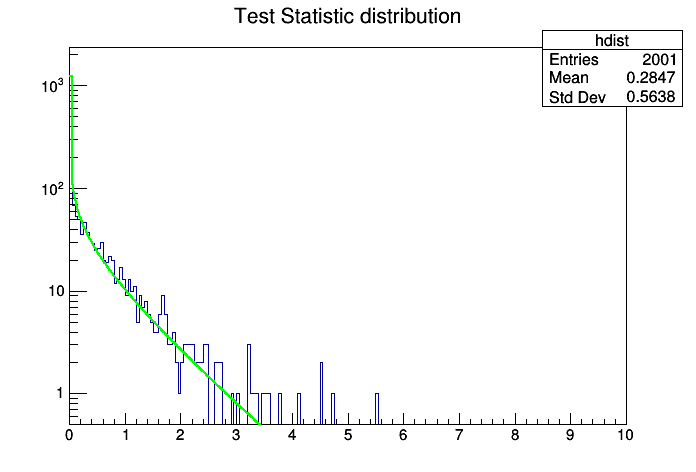

In [22]:
hdist->Draw();
fchi2->SetParameters(vec.size(),1);
fchi2->SetNpx(1000);
fchi2->SetLineColor(kGreen);
fchi2->DrawCopy("SAME");
fchi2->SetLineColor(kRed);
gPad->Draw();

In [23]:
// do integral fit 
hdist->Fit(fchi2,"L I ","SAME");

 FCN=48.0139 FROM MIGRAD    STATUS=CONVERGED      33 CALLS          34 TOTAL
                     EDM=2.86367e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.00001e+03   4.47216e+01   2.15084e-01   9.00834e-08
   2  p1           1.12205e+00   5.19618e-02   2.49543e-04  -3.16308e-04
                               ERR DEF= 0.5


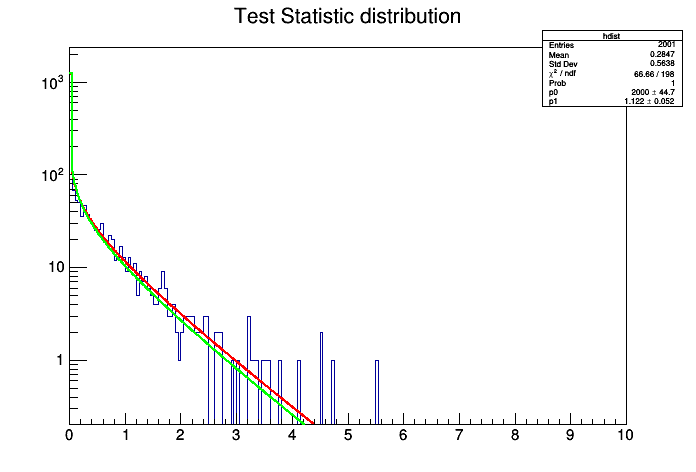

In [24]:
gStyle->SetOptFit(1111);
gPad->Draw();

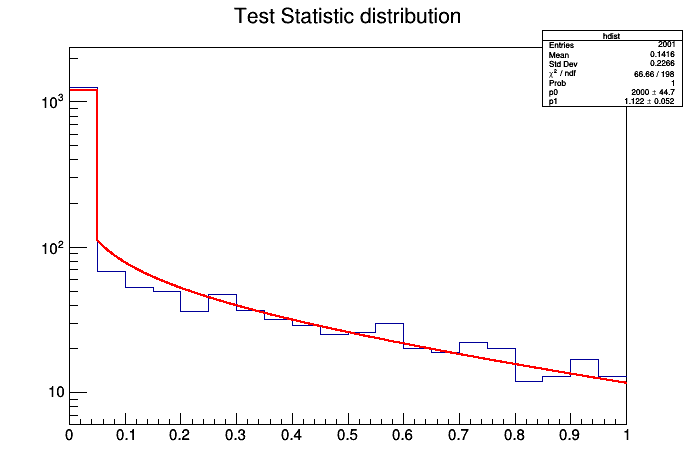

In [25]:
auto hdist2 = (TH1*) hdist->Clone();
hdist2->GetXaxis()->SetRange(1,20);
hdist2->Draw();
gPad->Draw();